## Generate the pkl files

Before you start, copy the script in [this script](https://github.com/ramp-kits/supernovae/blob/master/utils/serialize_lsst_sn_sims.py) to your local directory.


Choose a model to validate. In this example, we will work with MODEL01.
Using an environment with Python3, do in the command line

```
>> python serialize_lsst_sn_sims.py <LSST_sim_dir> --timed
```

where <LSST_sim_dir> is the directory where the FITS files for the model you will analyze are located.

In my case that was

```
>> python serialize_lsst_sn_sim.py ../../data/PLASTICC_2018-02-10/LSST_DDF_MODEL01/ --timed
```

This will create in your local directory a file named `LSST_DDF_MODEL01_train.pkl` which will be used from now on as the data source.

## Read the data

The functions bellow will convert the pkl file into pandas data frames

In [48]:
import gzip
import pickle
import pandas as pd
import numpy as np
from matplotlib import gridspec

LSST_FILTERS = 'ugrizY'


def read_data(filename):
    """Read data from pickled file to a pandas dataframe"""
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)

    X = to_dataframe(data)
    y = pd.get_dummies(X.type == 0, prefix='SNIa', drop_first=True)
    X = X.drop(columns=['type'])

    return X, y


def to_dataframe(data):
    """Converts from a python dictionary to a pandas dataframe"""
    for idx in data:
        sn = data[idx]
        for filt in LSST_FILTERS:
            sn['mjd_%s' % filt] = np.array(sn[filt]['mjd'])
            sn['fluxcal_%s' % filt] = np.array(sn[filt]['fluxcal'])
            sn['fluxcalerr_%s' % filt] = np.array(sn[filt]['fluxcalerr'])
            del sn[filt]
        sn.update(sn['header'])
        del sn['header']

    return pd.DataFrame.from_dict(data, orient='index')

Now you can use the data doing

In [2]:
X, y = read_data('LSST_DDF_MODEL50_train.pkl')

The `X` contain the data itself. You can take a look at what IDs are present in X by using

In [7]:
len(X.index[:100])

1

In [5]:
# Get one supernovae - the first in the list
X.iloc[0]

mjd_u           [59968.195, 59997.133, 59998.109, 59999.113, 6...
fluxcal_u       [-1.91316, -4.12298, 2.35498, 0.844363, 1.3591...
fluxcalerr_u    [2.4795, 1.97271, 1.75124, 2.04549, 1.58141, 1...
mjd_g           [59947.34, 59957.297, 59962.203, 59973.195, 59...
fluxcal_g       [1.77058, -0.244306, -0.317347, -0.669768, -1....
fluxcalerr_g    [5.05102, 2.10154, 0.832759, 1.41351, 2.97284,...
mjd_r           [59947.332, 59957.289, 59962.195, 59973.188, 5...
fluxcal_r       [0.209983, -0.146035, -1.21163, 1.4662, -1.343...
fluxcalerr_r    [1.24601, 1.37734, 0.843722, 1.09938, 1.7421, ...
mjd_i           [59947.348, 59957.305, 59962.211, 59973.203, 5...
fluxcal_i       [0.653277, -1.25016, 0.273663, 0.387701, 3.302...
fluxcalerr_i    [13.5119, 2.59679, 1.33352, 1.67036, 2.63054, ...
mjd_z           [59947.359, 59957.316, 59962.219, 59973.215, 5...
fluxcal_z       [-4.84883, 2.33852, 0.994424, -3.10595, -6.827...
fluxcalerr_z    [8.20591, 3.54133, 1.77483, 1.85464, 3.47789, ...
mjd_Y     

You can choose one specific SN through its ID. For example, if you wish to access the SN 1618,

In [18]:
X.loc[218536]

mjd_u           [59968.195, 59997.133, 59998.109, 59999.113, 6...
fluxcal_u       [-1.91316, -4.12298, 2.35498, 0.844363, 1.3591...
fluxcalerr_u    [2.4795, 1.97271, 1.75124, 2.04549, 1.58141, 1...
mjd_g           [59947.34, 59957.297, 59962.203, 59973.195, 59...
fluxcal_g       [1.77058, -0.244306, -0.317347, -0.669768, -1....
fluxcalerr_g    [5.05102, 2.10154, 0.832759, 1.41351, 2.97284,...
mjd_r           [59947.332, 59957.289, 59962.195, 59973.188, 5...
fluxcal_r       [0.209983, -0.146035, -1.21163, 1.4662, -1.343...
fluxcalerr_r    [1.24601, 1.37734, 0.843722, 1.09938, 1.7421, ...
mjd_i           [59947.348, 59957.305, 59962.211, 59973.203, 5...
fluxcal_i       [0.653277, -1.25016, 0.273663, 0.387701, 3.302...
fluxcalerr_i    [13.5119, 2.59679, 1.33352, 1.67036, 2.63054, ...
mjd_z           [59947.359, 59957.316, 59962.219, 59973.215, 5...
fluxcal_z       [-4.84883, 2.33852, 0.994424, -3.10595, -6.827...
fluxcalerr_z    [8.20591, 3.54133, 1.77483, 1.85464, 3.47789, ...
mjd_Y     

The y holds the IDs in crescent order

In [9]:
y[:10]

""
218536


## Plotting the Light curves

You can use the utility bellow to plot one (or a few) light curves

In [10]:
#Plot the data
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

LSST_FILTERS = 'ugrizY'

def plot_lightcurves(idx, X):    
    
    flux = []
    for f in LSST_FILTERS:
        if len(X.iloc[idx]['fluxcal_' + f]) > 0:
            flux.append(max(X.iloc[idx]['fluxcal_' + f]))
            
    for id_f, f in enumerate(LSST_FILTERS):
        
        
        ax = axes[id_f // 3, id_f % 3]
        ax.errorbar(X.iloc[idx]['mjd_%s' % f] - X.iloc[idx]['pkmjd'], 
                    X.iloc[idx]['fluxcal_%s' % f]/max(flux), 
                    X.iloc[idx]['fluxcalerr_%s' % f]/max(flux), 
                    fmt='o')
        ax.set_xlabel('MJD')
        ax.set_ylabel('Calibrated flux')
        ax.set_title('%s-band' % f)

The functionality bellow will plot light curves in sequence, order by ID

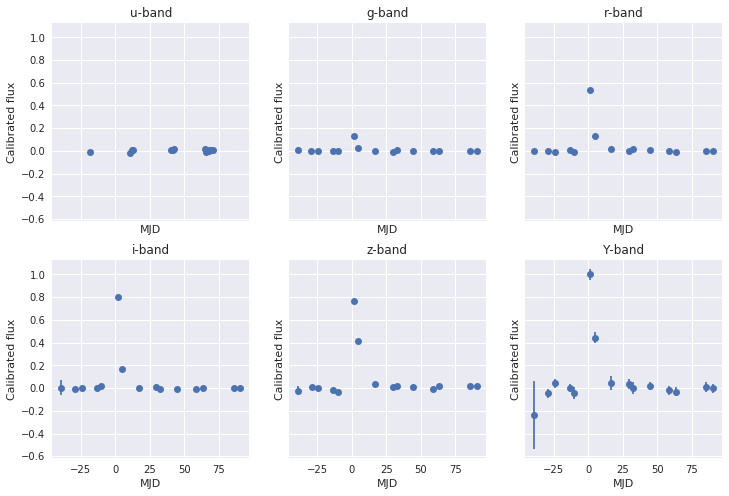

In [92]:
# set the number of light curves to plot
nplots = 1

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in range(nplots):
    plot_lightcurves(i, X)

If you wish to plot one specific light curve, e.g. again SN 1618,

In [99]:
def plot_lightcurves_id(idx, X):    
    
    flux = []
    for f in LSST_FILTERS:
        if len(X.loc[idx]['fluxcal_' + f]) > 0:
            flux.append(max(X.loc[idx]['fluxcal_' + f]))
            
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))        
            
    for id_f, f in enumerate(LSST_FILTERS):
        
        
        ax = axes[id_f // 3, id_f % 3]
        ax.errorbar(X.loc[idx]['mjd_%s' % f] - X.iloc[idx]['pkmjd'], 
                    X.loc[idx]['fluxcal_%s' % f]/max(flux), 
                    X.loc[idx]['fluxcalerr_%s' % f]/max(flux), 
                    fmt='o')
        ax.set_xlabel('MJD')
        ax.set_ylabel('Calibrated flux')
        ax.set_title('%s-band' % f)

In [101]:
#plot_lightcurves_id(218536, X)

## Example of population tests

Bellow are just a few examples I could quickly think of. 
Feel free to add as much as you want

### Flux values

Check the minimum and maximum values for all filters

In [21]:
max_flux = {}
min_flux = {}

# for each filter
for f in LSST_FILTERS:
    max_flux[f] = []
    min_flux[f] = []
    
    # get the flux values
    for indx in range(len(X)):
        if len(X.iloc[indx]['fluxcal_' + f]) > 0:
            max_flux[f].append(max(X.iloc[indx]['fluxcal_' + f]))
            min_flux[f].append(min(X.iloc[indx]['fluxcal_' + f]))                   

After this information is gathered we can check the the distribution of its values

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))     
for id_f, f in enumerate(LSST_FILTERS):        
    ax = axes[id_f // 3, id_f % 3]
    ax.hist(max_flux[f])
    ax.set_xlabel('Max flux')
    ax.set_ylabel('Number of objects')
    ax.set_title('%s-band' % f)

In [23]:
for f in LSST_FILTERS:
    print(max(max_flux[f]))

3.78104
26.9528
108.87
162.737
155.937
202.504


Same thing for minimum values

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))     
for id_f, f in enumerate(LSST_FILTERS):        
    ax = axes[id_f // 3, id_f % 3]
    ax.hist(min_flux[f])
    ax.set_xlim(min(min_flux[f]), max(min_flux[f]))
    ax.set_xlabel('Min flux')
    ax.set_ylabel('Number of objects')
    ax.set_title('%s-band' % f)

In [25]:
for f in LSST_FILTERS:
    print(min(min_flux[f]), max(min_flux[f]))

-4.12298 -4.12298
-1.29395 -1.29395
-2.12721 -2.12721
-2.05972 -2.05972
-6.82765 -6.82765
-47.774 -47.774


## Compare with ideal simulations

We are going to plot this against other simulations.

In [56]:
#dat = np.genfromtxt('/project/rkessler/dscolnic/GW170817/LSST.LCPLOT_example.TEXT',dtype='str')
mjd1,flux1,fluxe1,flag1,filt1 = np.loadtxt('LSST.LCPLOT_example.TEXT', usecols=(2,4,5,6,7), unpack=True, dtype='str', skiprows=2)

['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1']


mjd1[xx[0]] [ 62624.227  62657.121] [ 0.77604  5.2716 ] ['u' 'g' 'g' 'r' 'r' 'r' 'r' 'i' 'i' 'i' 'i' 'i' 'z' 'Y' 'Y' 'Y'] 0
mjd1[xx[0]] [ 62630.25   62644.281  62649.152  62652.133] [ 134.33       1.478      0.95486   -0.29016] ['u' 'g' 'g' 'r' 'r' 'r' 'r' 'i' 'i' 'i' 'i' 'i' 'z' 'Y' 'Y' 'Y'] 1
mjd1[xx[0]] [ 62632.254  62643.238  62653.195  62655.223  62656.121] [ 34.634    -7.7425    1.6151    0.61847   1.075  ] ['u' 'g' 'g' 'r' 'r' 'r' 'r' 'i' 'i' 'i' 'i' 'i' 'z' 'Y' 'Y' 'Y'] 2
mjd1[xx[0]] [ 62633.242] [ 32.252] ['u' 'g' 'g' 'r' 'r' 'r' 'r' 'i' 'i' 'i' 'i' 'i' 'z' 'Y' 'Y' 'Y'] 3
mjd1[xx[0]] [ 62637.266  62639.227  62642.332] [-23.458  55.96  -15.432] ['u' 'g' 'g' 'r' 'r' 'r' 'r' 'i' 'i' 'i' 'i' 'i' 'z' 'Y' 'Y' 'Y'] 4


(-44.28100000000268, 35.945999999996275)

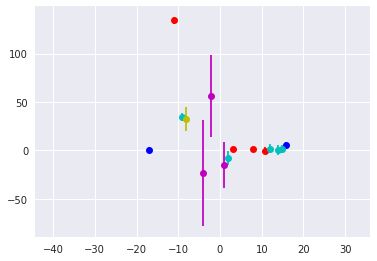

In [102]:
mjd1=mjd1.astype(float)
flux1=flux1.astype(float)
fluxe1=fluxe1.astype(float)
import matplotlib.ticker as ticker
str2a=['g','r','i','z','Y']
col=['b','r','c','y','m','y','r','g','m','b','g']
pos=[]

for i in range(1,299):
    pos.append(i-35)
    
pos2=[]

for i in range(1,299):
    pos2.append(0.0/100.0+0)
    
gs1 = gridspec.GridSpec(1, 1)
gs1.update(bottom=0.15, top=0.95, hspace=0.05)
ax1= plt.subplot(gs1[0])
zred=['0.05','0.4','0.68']
names=['LSST example','WFIRST example','PS1-380040']
for i in range(0,5):
    #line, = ax1.plot(pos, pos2, lw=2)

    xx=np.where((filt1==str2a[i]) & (flag1=='1'))
    print('mjd1[xx[0]]', mjd1[xx[0]], flux1[xx[0]], filt1, i)
    ax1.errorbar(mjd1[xx[0]]+3-62644.281, flux1[xx[0]], yerr=fluxe1[xx[0]], fmt='o', color=col[i],label=str2a[i])
    xx=np.where((filt1==str2a[i]) & (flag1=='0'))
    
    #line, = ax1.plot(mjd1[xx[0]]-62644.281, flux1[xx[0]], lw=2, color=col[i])
#ax1.text(40,650,"z="+zred[0])
#ax1.text(40,900,names[0])
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

lowlim= 62600-62644.281
uplim=62680.227-62644.281

ax1.set_xlim(lowlim,uplim)
#ax1.set_ylim(-60,260.0)



And plot some ID

Suppose we wish to compare our pet project SN 1618 from the non-ideal simuations. We can check its redshift:

In [73]:
z1618 = X.z[1618]
z1618

1.1337954998016357

now which ideal simulations are close to it in redshift

In [137]:
neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - z1618) <= 0.001] 
neighbors[:10]

[741, 892, 1694, 1791, 1945, 2099, 2339, 3118, 3244, 3391]

Plot them all

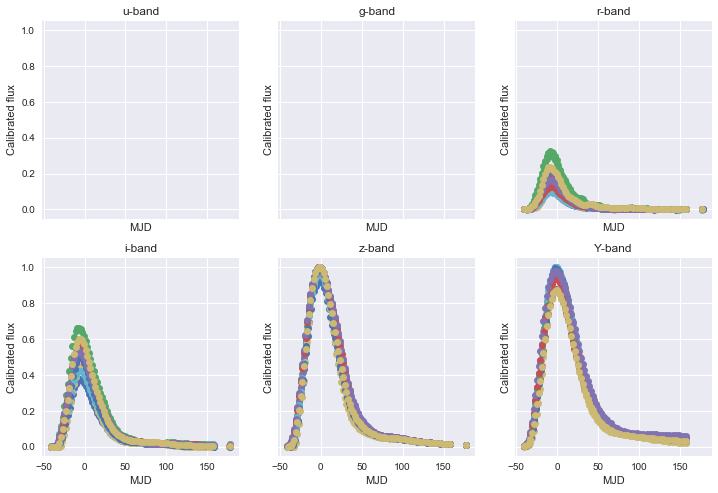

In [138]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in neighbors:
    plot_lightcurves(i, X1)

Superimpose the non-ideal light curve.

In [148]:
snid = 1618

def plot_lightcurves_ideal_compare(snid, X, neighbors, X1):  
    
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8)) 
    
    for idx in neighbors:
        flux = []
        for f in LSST_FILTERS:
            if len(X1.iloc[idx]['fluxcal_' + f]) > 0:
                flux.append(max(X1.iloc[idx]['fluxcal_' + f]))
   
        for id_f, f in enumerate(LSST_FILTERS):
            ax = axes[id_f // 3, id_f % 3]
            ax.errorbar(X1.iloc[idx]['mjd_%s' % f] - X1.iloc[idx]['pkmjd'], 
                        X1.iloc[idx]['fluxcal_%s' % f]/max(flux), 
                        X1.iloc[idx]['fluxcalerr_%s' % f]/max(flux), 
                        fmt='o')
            ax.set_xlabel('MJD')
            ax.set_ylabel('Calibrated flux')
            ax.set_title('%s-band' % f)
    
    flux2 = []
    for f in LSST_FILTERS:
        if len(X.loc[snid]['fluxcal_' + f]) > 0:
            flux2.append(max(X.loc[snid]['fluxcal_' + f]))
    
    for id_f, f in enumerate(LSST_FILTERS):
        ax = axes[id_f // 3, id_f % 3]
        ax.errorbar(X.loc[snid]['mjd_%s' % f] - X.loc[snid]['pkmjd'], 
                    X.loc[snid]['fluxcal_%s' % f]/max(flux), 
                    X.loc[snid]['fluxcalerr_%s' % f]/max(flux), 
                    fmt='o', color='black')
        ax.set_xlabel('MJD')
        ax.set_ylabel('Calibrated flux')
        ax.set_title('%s-band' % f)

In the plot bellow, the black points corresponto the realistic light curve and the other colors to perfect simulations (high cadence and no noise)

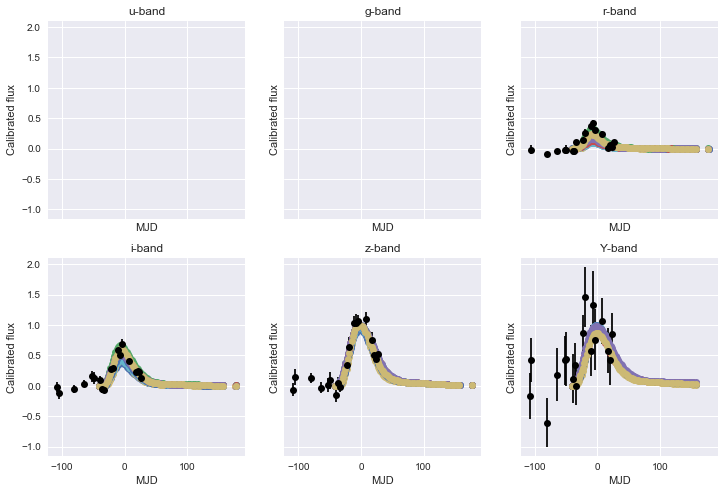

In [149]:
plot_lightcurves_ideal_compare(snid, X, neighbors, X1)